<a href="https://colab.research.google.com/github/UlyShel/basics_of_machine_learning/blob/main/HW4_%D0%98%D0%90%D0%94_%D0%A8%D0%B5%D0%BB%D0%B5%D0%B3%D0%BE%D0%B2%D0%B0_%D0%A3%D0%BB%D1%8C%D1%8F%D0%BD%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Интеллектуальный анализ данных – весна 2024
## Домашнее задание 4: kNN. Линейные модели. Работа с признаками

Правила:

* Домашнее задание оценивается в 10 баллов.

* Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.

* Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.

* Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

* Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.  

### Задание 1:  Визуализация решающих поверхностей в kNN.

В этом задании мы изобразим решающую поверхность для классификатора kNN, чтобы наглядно увидеть, как классификатор принимает решения для новых объектов. Для простоты будем работать со встроенным в `sklearn` набором данных `wine`, содержащим информацию о характеристиках трёх видов вина. Описание набора можно найти [здесь](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html#sklearn.datasets.load_wine) и [здесь](https://rdrr.io/cran/rattle.data/man/wine.html).

Загрузим набор данных и сохраним информацию о признаках в переменную `X`, а о зависимой переменной – в переменную `y`.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from sklearn.datasets import load_wine

data = load_wine()
X = pd.DataFrame(data['data'], columns = data['feature_names'])
y = data['target']
X.head(8)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
5,14.20,1.76,2.45,15.2,112.0,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450.0
6,14.39,1.87,2.45,14.6,96.0,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290.0
7,14.06,2.15,2.61,17.6,121.0,2.60,2.51,0.31,1.25,5.05,1.06,3.58,1295.0


**Задача 1.1 (0.5 балла)** Есть ли в наборе данных пропущенные значения? Если да, то удалите их. Есть ли в наборе данных категориальные переменные? Если да, то закодируйте их при помощи OneHot-кодирования. Используйте [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html).

In [ ]:
print(f'Есть пропущенные данные: {X.isna().values.any()}')

Есть пропущенные данные: False


In [ ]:
X_category = (X.dtypes=='object').values
print(f'Есть ли категориальные переменные: {X_category.any()}')

Есть ли категориальные переменные: False


**Задача 1.2 (0.5 балла)** Используя функцию `train_test_split()`, разделите выборку на тренировочную и тестовую, и долю тестовой выборки задайте равной 0.3. Так как разбиение осуществляется случайным образом, не забудьте зафиксировать `np.random.seed()` для воспроизводимости результатов.

Используйте аргумент `stratify` при разбиении. Почему это важно?

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
np.random.seed(66)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y)

# 2 вариант для зафиксирования воспроизводимости
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=66, shuffle=True, stratify=y)

Аргумент stratify важен, потому что позволяет работать с несбалансированными датасетами (https://ioflood.com/blog/train-test-split-sklearn/). Например, на лекции приводился пример, когда на обучающей выборке 98% процентов больных и лишь 2% относятся к классу здоровых. Если мы сделаем модель, которая будет выдавать класс "болен" всегда, то функционал ошибки на обучающей выборке будет невелик как раз из-за неравного соотношения классов, хотя на тестовой выборке все может быть более сбалансировано, и модель не сможет работать корректно. Таким образом в аналагогичной ситуации, когда в изначальном дата сете классы распределены не особо сбалансировано, или для того, чтобы предотвратить такую ситуацию при разделении даты на тестовую и обучающую выборку, полезно использовать stratify.

If not None, data is split in a stratified fashion, using this as the class labels (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). В нашем случае мы делим дату в соотвествии с y (классы в этом случае: 1, 2, 3).  



**Задача 1.3 (1 балл)** На тренировочной выборке обучите шесть классификаторов kNN, отличающихся только числом соседей. Для первого классификатора число соседей поставьте равным 1, для второго - 3, для третьего – 5, для четвертого – 10, для пятого – 15 и для шестого – 25 (обратите внимание на параметр `n_neighbours` класса `KNeighborsClassifier`). Для обучения используйте только два признака: `alcohol` и `magnesium` – и евклидово расстояние. Не забудьте масштабировать признаки, например, при помощи модуля `StandardScaler`.

Выведите долю правильных ответов на тренировочной и тестовой выборках для каждого классификатора.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

In [ ]:
X_knn = X[['alcohol', 'magnesium']]
y_knn = data['target']

normalize = StandardScaler()
X_knn_norm = normalize.fit_transform(X_knn)
X_knn_norm = pd.DataFrame(data=X_knn_norm)

X_knn_train, X_knn_test, y_knn_train, y_knn_test = train_test_split(X_knn_norm, y_knn, random_state=66, test_size=0.3, shuffle=True)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
all_neighbors = [1, 3, 5, 10, 15, 25]
all_clfs = []

print('NN\tTrain\tTest')
for neighbor in all_neighbors:
  clf = KNeighborsClassifier(n_neighbors=neighbor, metric='euclidean')
  clf.fit(X_knn_train, y_knn_train)
  all_clfs.append(clf)

  y_predicted_train = clf.predict(X_knn_train)
  y_predicted_test = clf.predict(X_knn_test)

  train_accuracy = accuracy_score(y_predicted_train, y_knn_train)
  test_accuracy = accuracy_score(y_predicted_test, y_knn_test)

  print(f'{int(neighbor)}\t{round(float(train_accuracy), 2)}\t{round(float(test_accuracy), 2)}')

NN	Train	Test
1	0.99	0.69
3	0.83	0.7
5	0.78	0.74
10	0.73	0.8
15	0.71	0.74
25	0.7	0.8


**Задача 1.4 (0 баллов)** Установите библиотеку `mlxtend` командой ниже. Библиотеку также можно установить из терминала при помощи `pip` или `conda`, как указано [здесь](http://rasbt.github.io/mlxtend/installation/).

In [ ]:
!pip install mlxtend

Если всё прошло успешно, то в выводе команды выше вы увидите сообщение вроде "successfully installed", а следующая ячейка выполнится без ошибок.

In [ ]:
import mlxtend

**Задача 1.5 (1 балл)** Библиотека `mlxtend` позволяет достаточно просто визуализировать решающие поверхности обученных классификаторов. Изучите [документацию](http://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/) библиотеки и найдите, как можно построить несколько графиков решающих поверхностей на сетке (decision regions grid). Постройте такую сетку графиков для обученных выше классификаторов.

**Подсказки:**
1. Вы можете использовать готовый код, приведённый в документации, и адаптировать его для нашего случая.
2. Вам могут понадобиться дополнительные библиотеки, которые используются в примере из документации.
3. Обратите внимание на то, как нужно изменить параметры `gridspec.GridSpec()` и `itertools.product()` для нашего числа классификаторов.
4. В функции `plot_decision_region()` используйте `y_train` и нужные столбцы из `X_train`. Возможно, их придётся перевести в формат массива `numpy`.
5. Если в задаче 1.3 вы сохраните обученные классификаторы в список, то не будет необходимости обучать их заново.
6. Построение графика может занять некоторое время – придётся немного подождать!

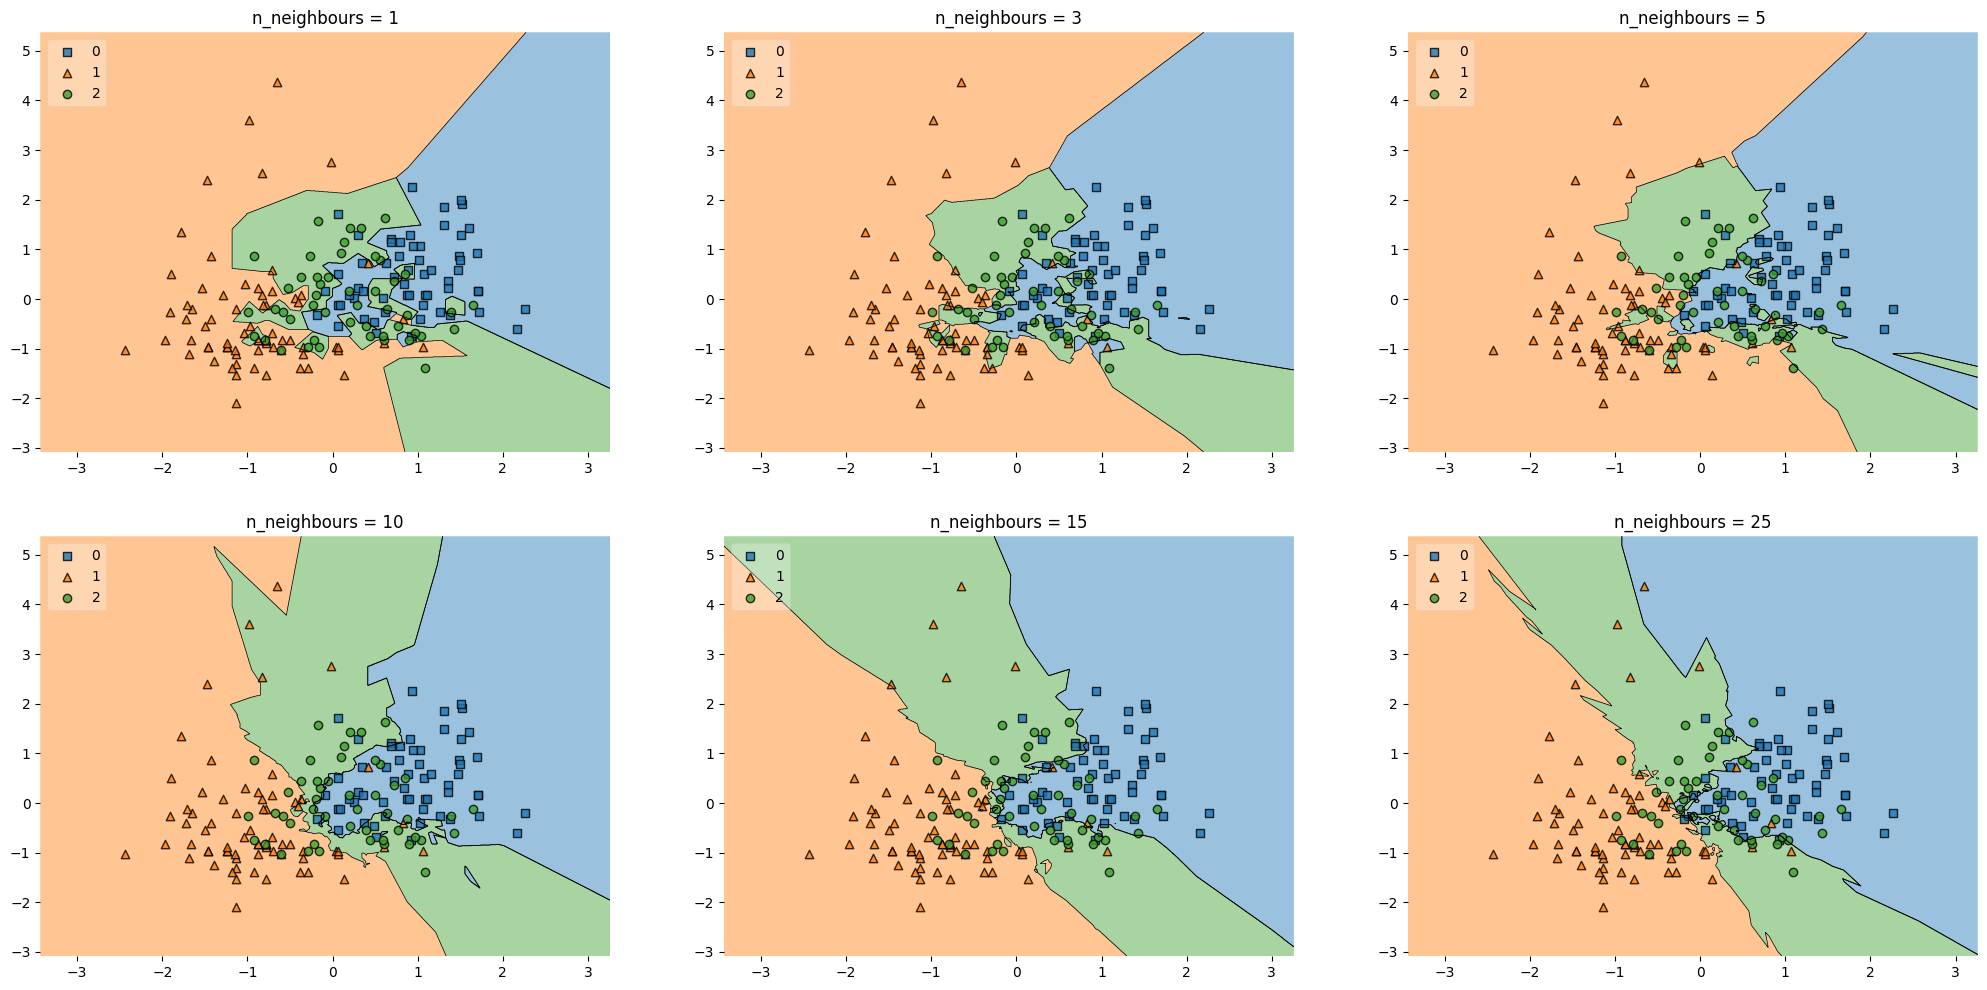

In [ ]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools
gs = gridspec.GridSpec(2, 3)

fig = plt.figure(figsize=(25, 12))

labels = ['n_neighbours = 1', 'n_neighbours = 3', 'n_neighbours = 5', 'n_neighbours = 10', 'n_neighbours = 15', 'n_neighbours = 25']
for clf, lab, grd in zip(all_clfs,
                         labels,
                         itertools.product([0, 1, 2], repeat=2)):

    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_knn_norm.values, y=y_knn, clf=clf, legend=2)
    plt.title(lab)


plt.show()

**Задача 1.6 (0.5 балла)** Прокомментируйте результаты, полученные в задачах 1.3 и 1.5. Какое число соседей оптимально использовать для обучения классификатора? Поясните ваш выбор при помощи описания геометрии данных и получаемой решающей поверхности. Какие из результатов явно говорят о переобучении модели? Почему?

In [ ]:
clf = KNeighborsClassifier(n_neighbors=26, metric='euclidean')
clf.fit(X_knn_train, y_knn_train)

y_predicted_train = clf.predict(X_knn_train)
y_predicted_test = clf.predict(X_knn_test)

train_accuracy = accuracy_score(y_predicted_train, y_knn_train)
test_accuracy = accuracy_score(y_predicted_test, y_knn_test)

print(f'{int(neighbor)}\t{round(float(train_accuracy), 2)}\t{round(float(test_accuracy), 2)}')

25	0.7	0.76


Оптимальное число соседей: 25 соседей, ведь это та модель, которая не демонстрирует переобучения (то есть, той ситуцаии, когда результат на тестовой выборке хуже, чем на обучающей) и дает достаточно гладкую геометрическую повехность без "островков". Так же, если проверить дальше, например, сделать n=30, то качество на тесте начинает ухудшаться.

Переобучение модели: при n = 1, 3 и 5, разделяющая поверхность очень неровная и результат на тестовой выборке хуже. Совсем явное переобученеи заметно для n=1.

### Задание 2. KNN своими руками. 2 Балла

В данном задании мы попробуем реализовать алгоритм KNN своими руками. В данном случае мы попробуем сделать KNN для классификации.

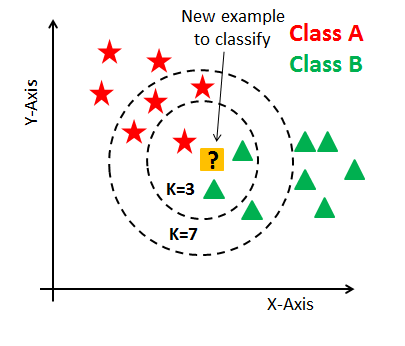

In [ ]:
import numpy as np
from collections import Counter

class KNN:
    def __init__(self, k:int):
      self.k = k

    def fit(self, X, y):
      self.X = X
      self.y = y

    def predict(self, X) -> list:
      res = []
      class_predict = {}
      for obj in X:
        distances = np.sqrt(np.sum((self.X - obj)**2, axis=1))
        for i, v in enumerate(distances):
          class_predict[i] = v
          class_predict = dict(sorted(class_predict.items(), key=lambda x: x[1]))
        predictions = list(class_predict.keys())[:self.k]
        y_predictions = self.y[predictions]
        cnt = Counter(y_predictions)
        res.append(sorted(dict(cnt).items(), key=lambda x: x[1])[-1][0])
      return res

    def count_distance(self, x, y):
      return np.sqrt(np.sum((x - y)**2))

In [ ]:
# Не меняйте файл!
def test_knn(KNN):
  knn = KNN(k=1)
  X_train =  np.array([[1, 1], [2, 2]])
  y_train =  np.array([0, 1])
  X_test =  np.array([[1.5, 1.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [0]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[9.5, 9.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[5.5, 5.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[15, 15]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[5, 5], [2, 2]])
  knn.fit(X_train, y_train)
  assert all([knn.predict(X_test) == [1, 0]])

In [ ]:
# Если тесты эти пройдены, то все верно!
test_knn(KNN)

### Задание 3: Линейная регрессия.

В этом задании мы рассмотрим различные аспекты построения линейной модели. Мы будем работать с одним из классических наборов данных в статистике, содержащим информацию о бриллиантах. Описание можно посмотреть [здесь](https://www.kaggle.com/shivam2503/diamonds).

In [ ]:
!pip install kaggle

import os
os.environ['KAGGLE_USERNAME'] = "ulyshel"
os.environ['KAGGLE_KEY'] = "a238fb664dfc92b2f805c2c15231a109"

! kaggle datasets download -d shivam2503/diamonds

import zipfile
with zipfile.ZipFile('/content/diamonds.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/HW4')

  0% 0.00/733k [00:00<?, ?B/s]
100% 733k/733k [00:00<00:00, 20.1MB/s]


In [ ]:
diamonds = pd.read_csv('/content/HW4/diamonds.csv')

In [ ]:
diamonds.head(5)

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [ ]:
y_diamonds = diamonds['price']
X_diamonds = diamonds.drop('price', axis=1)

Мы будем решать задачу предсказания цены бриллианта `price` в зависимости от его характеристик.

**Задача 3.1 (0.2 балла)** Есть ли в наборе данных пропущенные значения? Если да, удалите их.
Есть ли в наборе данных бессмысленные столбцы (признаки, не несущие дополнительной информации)? Если да, то удалите их.

In [ ]:
print(f'Есть пропущенные данные: {X_diamonds.isna().values.any()}')

Есть пропущенные данные: False


In [ ]:
del X_diamonds['Unnamed: 0']

Этот столбец не дает никакого описания объектов, потому что просто отражает порядковый номер объектов.

In [ ]:
X_diamonds.head(5)

,carat,cut,color,clarity,depth,table,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,4.34,4.35,2.75


**Задача 3.2 (0.1 балла)** Линейная регрессия основана на предположении о линейной связи между признаками и целевой переменной, а потому перед выбором переменных для включения в модель имеет смысл проверить, насколько эта связь выполняется. Для следующих пунктов нам также потребуются выборочные корреляции между признаками. Выведите матрицу выборочных корреляций между всеми вещественными признаками и целевой переменной (то есть в этой матрице будет $k+1$ строка, где $k$ – количество вещественных признаков).

Какие вещественные признаки коррелируют с целевой переменной больше всего?

In [ ]:
categorical_diamonds = (X_diamonds.dtypes == "object").values
num_diamonds = X_diamonds[X_diamonds.columns[~categorical_diamonds]]

X_y_diam = pd.concat([num_diamonds, y_diamonds], axis=1)

X_y_diam.corr()

,carat,depth,table,x,y,z,price
carat,1.000000,0.028224,0.181618,0.975094,0.951722,0.953387,0.921591
depth,0.028224,1.000000,-0.295779,-0.025289,-0.029341,0.094924,-0.010647
table,0.181618,-0.295779,1.000000,0.195344,0.183760,0.150929,0.127134
x,0.975094,-0.025289,0.195344,1.000000,0.974701,0.970772,0.884435
y,0.951722,-0.029341,0.183760,0.974701,1.000000,0.952006,0.865421
z,0.953387,0.094924,0.150929,0.970772,0.952006,1.000000,0.861249
price,0.921591,-0.010647,0.127134,0.884435,0.865421,0.861249,1.000000


Больше всего коррелируют:

**(1) carat** - сильная, позитивная зависимость (что логично, ведь это вес бриллианта);

**(2) x, y, z** - сильная позитивная зависимость (длина, ширина, толщина, что тоже логично - размеры бриллианты влияют на конечную стоимость. Маленькие бриллианты стоят дешевле, чем массивные)

**Задача 3.3 (0.1 балла)** Так как линейная модель складывает значения признаков с некоторыми весами, нам нужно аккуратно обработать категориальные признаки. Закодируйте категориальные переменные при помощи OneHot-кодирования.

In [ ]:
X_diamonds = pd.get_dummies(X_diamonds, drop_first=True)
X_diamonds

,carat,depth,table,x,y,z,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,3.95,3.98,2.43,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0.21,59.8,61.0,3.89,3.84,2.31,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2,0.23,56.9,65.0,4.05,4.07,2.31,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0.29,62.4,58.0,4.20,4.23,2.63,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
4,0.31,63.3,58.0,4.34,4.35,2.75,1,0,0,0,...,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53935,0.72,60.8,57.0,5.75,5.76,3.50,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
53936,0.72,63.1,55.0,5.69,5.75,3.61,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
53937,0.70,62.8,60.0,5.66,5.68,3.56,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
53938,0.86,61.0,58.0,6.15,6.12,3.74,0,0,1,0,...,1,0,0,0,0,1,0,0,0,0


**Задача 3.4 (0.2 балла)** Разделите выборку на тренировочную и тестовую. Долю тестовой выборки укажите равной 0.3. Не забудьте про параметр `stratify`.

In [ ]:
diam_X_train, diam_X_test, diam_y_train, diam_y_test = train_test_split(X_diamonds, y_diamonds, test_size=0.3, random_state=66)

В задачах линейной регрессии, stratify нет смысла использовать, потому что у нас нет классов для стратификации.

**Задача 3.5 (0.3 балла)** Зачастую при использовании линейных моделей вещественные признаки масштабируются. При этом оценки коэффициентов теряют прямую статистическую интерпретацию ("при увеличении $X_1$ на 1, $y$ увеличивается на $w_1$"), но приобретают свойства, полезные в задачах машинного обучения. В этой задаче масштабируйте вещественные признаки тренировочной и тестовой выборок при помощи модуля `StandardScaler`.

In [ ]:
normalize = StandardScaler()

diam_X_train_norm = pd.DataFrame(data=normalize.fit_transform(diam_X_train), columns = diam_X_train.columns)
diam_X_test_norm = pd.DataFrame(data=normalize.transform(diam_X_test), columns = diam_X_test.columns)

**Задача 3.6 (0.2 балла)** Оцените линейную регрессию на тренировочной выборке. Выведите среднеквадратичную ошибку на тренировочной и тестовой выборках.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(diam_X_train_norm, diam_y_train)

y_diam_train_predicted = lin_reg.predict(diam_X_train_norm)
y_diam_test_predicted = lin_reg.predict(diam_X_test_norm)

print(f"MSE на тренировочной выборке: {mean_squared_error(diam_y_train, y_diam_train_predicted)}")
print(f"MSE на тестовой выборке: {mean_squared_error(diam_y_test, y_diam_test_predicted)}")

MSE на тренировочной выборке: 1261425.9003372854
MSE на тестовой выборке: 1317094.1670389667


**Задача 3.7 (0.2 балла)** Изучите [документацию](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) модуля `LinearRegression` и выведите полученные оценки коэффициентов. Назовите вещественные переменные, оценки коэффициентов которых по модулю на порядок превышают оценки прочих вещественных переменных.

In [ ]:
coeff = abs(lin_reg.coef_)
coeff

array([5362.20615364,   80.63941548,   64.87243775, 1023.52495472,
         15.74444853,  181.95127333,  160.51142371,  392.63864247,
        321.97720772,  286.92932075,   75.80472587,  101.07077698,
        187.22034249,  346.35585848,  441.68377139,  522.10472489,
        967.63422348, 1616.81144357, 1067.11052671, 1675.63446181,
       1836.25191573, 1295.38512199, 1471.07238466])

In [ ]:
coeff_index = [coef for coef in diam_X_train.columns]

coeff_dct = dict(zip(coeff_index, list(coeff)))
dict(sorted(coeff_dct.items(), key=lambda x: x[1], reverse=True))

{'carat': 5362.206153639556,
 'clarity_VS2': 1836.251915732663,
 'clarity_VS1': 1675.6344618068802,
 'clarity_SI1': 1616.8114435689552,
 'clarity_VVS2': 1471.0723846619085,
 'clarity_VVS1': 1295.3851219924366,
 'clarity_SI2': 1067.1105267055455,
 'x': 1023.5249547200239,
 'clarity_IF': 967.6342234818642,
 'color_J': 522.1047248890956,
 'color_I': 441.68377138884574,
 'cut_Ideal': 392.6386424675488,
 'color_H': 346.3558584794226,
 'cut_Premium': 321.97720772260345,
 'cut_Very Good': 286.929320750293,
 'color_G': 187.22034249118173,
 'z': 181.95127332797486,
 'cut_Good': 160.51142371340904,
 'color_F': 101.07077698356963,
 'depth': 80.63941547764762,
 'color_E': 75.80472587012784,
 'table': 64.8724377525539,
 'y': 15.74444853024811}

Для удобства я отсортировала коэффицента в обратном порядке, чтобы не бегать по нп.аррэю глазами в посиках наибольших коэффицентов и не проверять, является ли этот столбец столбцом вещественных признаков.

Вещественные переменные, оценки коэффициентов которых по модулю на порядок превышают оценки прочих вещественных переменных: carat. Принадлежность к 'clarity_VS2' так же имеет значение, хоть это и категориальный признак.

Видна и очевидная обратная зависимость у x, то есть, чем меньше x (длина кольца), тем больше цена, и наоборот.  Мы это уже обсуждали в контексте матрицы корреляций

**Задача 3.8 (0.4 балла)** Как можно заметить из анализа корреляционной матрицы в задаче 3.3, между некоторыми признаками имеется сильная корреляция, что может быть индикатором проблемы *мультиколлинеарности*. Различия в порядке коэффициентов, выявленные в предыдущей задаче также намекают на её присутствие. Как известно, для решения этой проблемы можно либо исключить некоторые признаки из модели, либо использовать регуляризацию. Мы воспользуемся вторым вариантом.

Вспомним, что смысл регуляризации заключается в том, чтобы изменить функцию потерь так, чтобы устранить проблемы, появляющиеся из-за мультиколлинеарности. При L1-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \alpha\sum_{i=1}^k|w_i|
$$

Такая модель называется Lasso-регрессией.

При L2-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \frac{1}{2}\alpha\|w\|^2
$$

Такая модель называется Ridge-регрессией.

Обучите Lasso-регрессию и Ridge-регрессию, уставновив гиперпараметр регуляризации равным 10. Для этого используйте модули `Lasso` и `Ridge` из `sklearn`. Сильно ли уменьшились веса? Сделайте вывод о том, насколько сильно проблема мультиколлинеарности проявлялась в изначальной регрессии.

In [ ]:
from sklearn.linear_model import Lasso, Ridge

In [ ]:
lasso = Lasso(10.0).fit(diam_X_train_norm, diam_y_train)

ridge = Ridge(10.0).fit(diam_X_train_norm, diam_y_train)

In [ ]:
coef_lasso = pd.DataFrame(np.absolute(lasso.coef_), diam_X_train_norm.columns, columns=['lasso_coefs']).sort_values(by='lasso_coefs', ascending=False)

coef_lasso

,lasso_coefs
carat,4847.874975
clarity_VS2,1071.996821
clarity_VS1,1014.173653
clarity_VVS2,936.002517
clarity_SI1,836.776959
clarity_VVS1,831.286324
clarity_IF,632.549895
x,534.603491
color_J,462.444745
clarity_SI2,386.159926


In [ ]:
coef_ridge = pd.DataFrame(np.absolute(ridge.coef_), diam_X_train_norm.columns, columns=['ridge_coefs']).sort_values(by='ridge_coefs', ascending=False)

coef_ridge

,ridge_coefs
carat,5322.046478
clarity_VS2,1804.173703
clarity_VS1,1648.040134
clarity_SI1,1583.877232
clarity_VVS2,1448.960394
clarity_VVS1,1276.447364
clarity_SI2,1038.855925
x,970.646163
clarity_IF,954.159796
color_J,520.807495


Веса уменьшились не особо значительно, но, конечно, в случае с Лассо изменения более существенны, так, например, y занулился. Судя по всему, проблема мультиколлинеарности не особо проявлялась в изначальной регрессии.

**Задача 3.9 (0.4 балла)** Как обсуждалось на семинарах, Lasso-регрессию можно использовать для отбора наиболее информативных признаков. Для следующих значений параметра регуляриазции $\alpha$: 0.1, 1, 10, 100, 200 –  обучите Lasso- и Ridge-регрессии и постройте график измненения евклидовой нормы весов (`np.linalg.norm()` от вектора оценок коэффициентов) в зависимости от параметра $\alpha$. Как известно, норма является численной характеристикой величины вектора, а потому по норме можно судить о том, насколько большие элементы содержит вектор оценок коэффициентов.

Какой метод агрессивнее уменьшает веса? Поясните, почему Lasso-регрессию часто используют для отбора признаков.

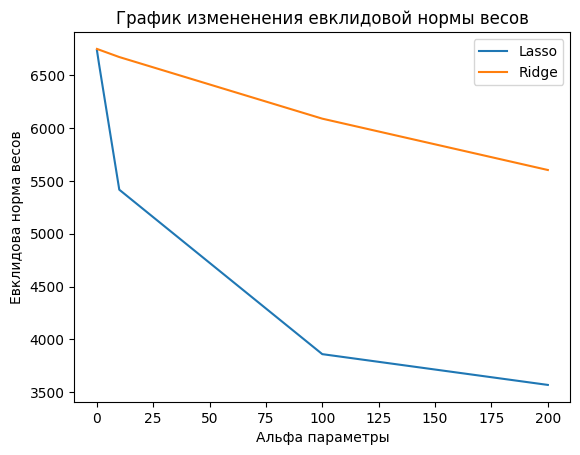

In [ ]:
alpha_param = [0.1, 1, 10, 100, 200]
euclidean_weight_lasso = []
euclidean_weight_ridge = []

for alpha in alpha_param:
  lasso = Lasso(alpha).fit(diam_X_train_norm, diam_y_train)
  ridge = Ridge(alpha).fit(diam_X_train_norm, diam_y_train)
  euclidean_weight_lasso.append(np.linalg.norm(lasso.coef_))
  euclidean_weight_ridge.append(np.linalg.norm(ridge.coef_))

plt.plot(alpha_param, euclidean_weight_lasso)
plt.plot(alpha_param, euclidean_weight_ridge)
plt.xlabel('Альфа параметры')
plt.ylabel('Евклидова норма весов')
plt.title('График измененения евклидовой нормы весов')
plt.legend(('Lasso', 'Ridge'));

Лассо более агрессивно уменьшает веса, потому что штрафует по их абсолютным значениям, именно поэтому многие коэффиценты просто зануляются. Ридж же штрафует по квардартам, лишь делая веса ближе к нулю.

Лассо используют, когда есть необходимость отобрать действительно значимые признаки, занулив ненужные или избыточные переменные. Более того, это упрощает интерпретацию модели,  потому что формула упрощается.

источники:
(1) https://www.mygreatlearning.com/blog/understanding-of-lasso-regression/

(2) https://it.kgsu.ru/ML_Begin/ML_beg040.html

**Задача 3.10 (0.5 балла)**
В зависимости от значения параметра $\alpha$ в Lasso-регрессии зануляются разные оценки коэффициентов. Оптимальное значение $\alpha$ можно подобрать, например, при помощи кросс-валидации по тренировочной выборке.

Для проведения кросс-валидации можно использовать модуль `LassoCV`. Этот модуль принимает список значений $\alpha$ (параметр `alphas`) и при обучении проводит кросс-валидацию для каждого значения из этого списка, сохраняя MSE на каждом участке кросс-валидации (количество участков – параметр `cv`) в матрицу ошибок (то есть итоговая матрица будет иметь размер `len(alphas)` $\times$ `cv`). После обучения модели матрицу ошибок можно получить, обратившись к атрибуту `.mse_path_`.

Заметим, что модель может использовать $\alpha$ не в том порядке, в котором вы подаёте их в функцию: для определения порядка используйте атрибут `.alphas_` Установите количество участков для кросс-валидации (параметр `cv`) равным 5.

Усредните ошибки для каждого значения $\alpha$ (то есть по строкам матрицы ошибок) и выберите то значение, которое даёт наибольшее качество.

In [ ]:
from sklearn.linear_model import LassoCV

In [ ]:
lasscv = LassoCV(cv=5, alphas = [0.1, 1, 10, 100, 200]).fit(diam_X_train_norm, diam_y_train)

matrix = lasscv.mse_path_
matrix_mean = np.mean(matrix, axis=1)

# 1 способ выбрать то значение, которое даёт наибольшее качество:
print(f'\nЗначение альфа с лучшим качеством: {lasscv.alphas_[np.argmin(matrix_mean)]}')

# 2 способ выбрать то значение, которое даёт наибольшее качество:
# lasscv.alpha_

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 298359005.93862915, tolerance: 47536467.03971325
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9929659223.09262, tolerance: 47536467.03971325
  model = cd_fast.enet_coordinate_descent_gram(



Значение альфа с лучшим качеством: 1.0


**Задача 3.11 (0.5 балла)** Обучите итоговую Lasso-регрессию с выбранным параметром $\alpha$ на тренировочной выборке. Выведите полученные коэффициенты и прокомментируйте, какие признаки оказались неинформативными, а какие – наиболее информативными. Приведите возможное смысловое объяснение этого результата.

In [ ]:
lasso_res = Lasso(1.0).fit(diam_X_train_norm, diam_y_train)

coef_lasso_res = pd.DataFrame(np.absolute(lasso_res.coef_), diam_X_train_norm.columns, columns=['lasso_coefs_res']).sort_values(by='lasso_coefs_res', ascending=False)
coef_lasso_res

,lasso_coefs_res
carat,5314.518449
clarity_VS2,1759.120063
clarity_VS1,1608.870716
clarity_SI1,1538.133002
clarity_VVS2,1417.025452
clarity_VVS1,1248.461121
clarity_SI2,998.429278
x,982.101641
clarity_IF,933.743336
color_J,516.189769


Признак y (ширина кольца), как оказалось, не является неинформативным даже при Lasso = 1, и коэффицент при нем занулился. Можно предположить, что он не оказывает влияние на пресказание модели, потому что не имеет прямого влияния на цену. Это вызвано тем, что, хотя этот признак и можо посчитать важным, потому что стоимость зависит и от визуального восприятия камня. Тем не менее, этот признак скорее работает в совокупности с другими, например, с весом, чистотой и длиной, именно поэтому лассо-регрессия не учитывает его для простоты модели.

В свою очередь признаки carat (вес бриллианта), чистота все так же остаются наиболее влиятельными и информативными, потому что в целом являются основными критериями стоимости бриллианта

**Задача 3.12 (0.4 балла)** Сделайте предсказания обученной Lasso-регрессии на тестовой выборке и сравните среднеквадратичную ошибку с ошибкой обычной линейной регрессии из задачи 3.7. Какую модель лучше использовать для предсказаний? Приведите возможное объяснение, почему одна модель оказалась лучше другой.

In [ ]:
y_diam_test_predicted_res = lasso_res.predict(diam_X_test_norm)

print(f"MSE на тестовой выборке для обычной линейной регрессии: {mean_squared_error(diam_y_test, y_diam_test_predicted)}")
print(f"MSE на тестовой выборке для обученной Lasso-регрессии: {mean_squared_error(diam_y_test, y_diam_test_predicted_res)}")

MSE на тестовой выборке для обычной линейной регрессии: 1317094.1670389667
MSE на тестовой выборке для обученной Lasso-регрессии: 1315558.9944424054


В целом в нашем конкретном случае ошибка уменьшилась незначительно, а потому использование Lasso регрессии было необязательным, хотя бы потому, что проблема мультиколлинеарности не проявилась и в изначальной регрессии и количество признаков едва ли можно назвать большим (иначе зануление было бы необходимо!). Тем не менее, в обратной ситуации, конечно, использование лассо или ридж-регрессии спасает.